In [0]:
  %matplotlib inline


Reinforcement Learning (DQN) Tutorial
=====================================
**Author**: `Adam Paszke <https://github.com/apaszke>`_


This tutorial shows how to use PyTorch to train a Deep Q Learning (DQN) agent
on the CartPole-v0 task from the `OpenAI Gym <https://gym.openai.com/>`__.

**Task**

The agent has to decide between two actions - moving the cart left or
right - so that the pole attached to it stays upright. You can find an
official leaderboard with various algorithms and visualizations at the
`Gym website <https://gym.openai.com/envs/CartPole-v0>`__.

.. figure:: /_static/img/cartpole.gif
   :alt: cartpole

   cartpole

As the agent observes the current state of the environment and chooses
an action, the environment *transitions* to a new state, and also
returns a reward that indicates the consequences of the action. In this
task, the environment terminates if the pole falls over too far.

The CartPole task is designed so that the inputs to the agent are 4 real
values representing the environment state (position, velocity, etc.).
However, neural networks can solve the task purely by looking at the
scene, so we'll use a patch of the screen centered on the cart as an
input. Because of this, our results aren't directly comparable to the
ones from the official leaderboard - our task is much harder.
Unfortunately this does slow down the training, because we have to
render all the frames.

Strictly speaking, we will present the state as the difference between
the current screen patch and the previous one. This will allow the agent
to take the velocity of the pole into account from one image.

**Packages**


First, let's import needed packages. Firstly, we need
`gym <https://gym.openai.com/docs>`__ for the environment
(Install using `pip install gym`).
We'll also use the following from PyTorch:

-  neural networks (``torch.nn``)
-  optimization (``torch.optim``)
-  automatic differentiation (``torch.autograd``)
-  utilities for vision tasks (``torchvision`` - `a separate
   package <https://github.com/pytorch/vision>`__).




In [0]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Replay Memory
-------------

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [0]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Now, let's define our model. But first, let quickly recap what a DQN is.

DQN algorithm
-------------

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. It makes rewards from the uncertain far
future less important for our agent than the ones in the near future
that it can be fairly confident about.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`__. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

Q-network
^^^^^^^^^

Our model will be a convolutional neural network that takes in the
difference between the current and previous screen patches. It has two
outputs, representing $Q(s, \mathrm{left})$ and
$Q(s, \mathrm{right})$ (where $s$ is the input to the
network). In effect, the network is trying to predict the *quality* of
taking each action given the current input.




In [0]:
class DQN(nn.Module):

    def __init__(self, input_size):
        super(DQN, self).__init__()
        self.lin1 = nn.Linear(input_size, 100).double()
        self.bn1 = nn.LayerNorm(100).double()
        self.head = nn.Linear(100, env.action_space.n).double()

    def forward(self, x):
        x = self.lin1(x)
        x = self.bn1(x)
        x = F.relu(x)
        return self.head(x)

Training
--------

Hyperparameters and utilities
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
This cell instantiates our model and its optimizer, and defines some
utilities:

-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
-  ``plot_durations`` - a helper for plotting the durations of episodes,
   along with an average over the last 100 episodes (the measure used in
   the official evaluations). The plot will be underneath the cell
   containing the main training loop, and will update after every
   episode.




In [0]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

policy_net = DQN(env.observation_space.shape[0]).to(device)
target_net = DQN(env.observation_space.shape[0]).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(1000000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            temp = policy_net(state)
            temp = temp.sum(dim=0)
            return temp.max(0)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)


episode_durations = []
episode_rewards = []

def plot_durations():
    if len(episode_durations) >= 100:
      print(np.mean(episode_durations[-99:]))
    else:
      print(np.mean(episode_durations))

def plot_rewards():
    if len(episode_rewards) >= 100:
      return (np.mean(episode_rewards[-99:]))
    else:
      return (np.mean(episode_rewards))

Training loop
^^^^^^^^^^^^^

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By defition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network has its weights kept frozen most of
the time, but is updated with the policy network's weights every so often.
This is usually a set number of steps but we shall use episodes for
simplicity.




In [0]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device, dtype=torch.double)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Below, you can find the main training loop. At the beginning we reset
the environment and initialize the ``state`` Tensor. Then, we sample
an action, execute it, observe the next screen and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Below, `num_episodes` is set small. You should download
the notebook and run lot more epsiodes.




In [0]:
saved_episodes = []
num_episodes = 1000
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = torch.zeros(env.observation_space.shape, dtype=torch.double).to(device)
    last_screen = last_screen.unsqueeze(0)
    current_screen = torch.zeros(env.observation_space.shape, dtype=torch.double).to(device)
    current_screen = current_screen.unsqueeze(0)
    state = current_screen - last_screen
    reward_total = 0
    cur_episode = []
    for t in count():
        # Select and perform an action
        action = select_action(state)
        obs, reward, done, _ = env.step(action.item())
        reward_total += reward
        reward = torch.tensor([reward], device=device)
        cur_episode.append(obs)
        # Observe new state
        last_screen = current_screen
        current_screen = torch.tensor(obs, dtype=torch.double).to(device)
        current_screen = current_screen.unsqueeze(0)
        if t == 199:
          done = True
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            saved_episodes.append(cur_episode)
            episode_rewards.append(reward_total)
            episode_durations.append(t + 1)
            break
    if i_episode % 10 == 0:
            print(f' {i_episode}: {plot_rewards()}')
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
#env.render()
#env.close()
plt.ioff()
plt.show()

 0: 26.0
 10: 20.09090909090909
 20: 20.761904761904763
 30: 20.35483870967742
 40: 21.29268292682927
 50: 23.647058823529413
 60: 23.40983606557377
 70: 23.281690140845072
 80: 22.28395061728395
 90: 21.087912087912088
 100: 20.454545454545453
 110: 20.383838383838384
 120: 21.515151515151516
 130: 22.717171717171716
 140: 22.0
 150: 22.696969696969695
 160: 23.767676767676768
 170: 23.77777777777778
 180: 27.2020202020202
 190: 30.414141414141415
 200: 32.64646464646464
 210: 33.04040404040404
 220: 37.343434343434346
 230: 41.36363636363637
 240: 48.95959595959596
 250: 50.64646464646464
 260: 53.78787878787879
 270: 66.92929292929293
 280: 67.26262626262626
 290: 71.36363636363636
 300: 85.87878787878788
 310: 94.48484848484848
 320: 102.83838383838383
 330: 110.23232323232324
 340: 118.96969696969697
 350: 132.75757575757575
 360: 138.3030303030303
 370: 142.14141414141415
 380: 156.53535353535352
 390: 166.6969696969697
 400: 166.0909090909091
 410: 175.17171717171718
 420: 178.4

In [0]:
moving_average = []
for i in range(len(episode_rewards)):
    if i < 50:
      moving_average.append(np.mean(episode_rewards[:i]))
    else:
      moving_average.append(np.mean(episode_rewards[i-50:i]))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


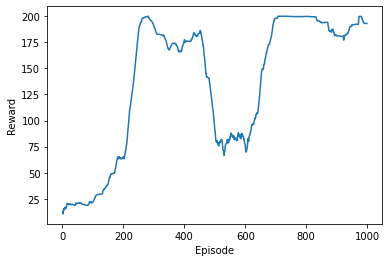

In [0]:
plt.plot(moving_average)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

In [0]:
print(len(saved_episodes))
print(type(saved_episodes[0][0]))
print(max([len(x) for x in saved_episodes]))

1000
<class 'numpy.ndarray'>
200


In [0]:
"""output_array = []
for i in range(len(saved_episodes)):
    temp = np.expand_dims(np.full((200, 4), -999, dtype='float64'), 0)
    episode = np.array(saved_episodes[i])
    temp[0, :len(saved_episodes[i]), :] = episode
    output_array.append(temp)
output_array = np.concatenate(output_array)"""
output_array = np.array(saved_episodes, dtype=object)

In [0]:
output_array.shape

(1000,)

In [0]:
np.save('saved_episodes.npy', output_array)